# Planning Evaluation Framework - Evaluation of Single Publisher Models
  
  This colab demonstrates the following things:

  1. How to fetch the planning evaluation framework from github and make it available for use in colab.
  2. How to create data sets representing single publishers and graph them.
  3. How to fit reach models to single publisher data sets.

Most of the cells in this colab should not be changed, but there are a few where you can insert parameter values of your own.  These cells are identified in <font color='red'>red</font>.

### Preliminary Step 0 (Googlers Only): Make sure you are using colab.sandbox.google.com

### Preliminary Step: Download and setup the Planning Evaluation Framework

In [1]:
!git clone https://github.com/world-federation-of-advertisers/planning-evaluation-framework
!cd planning-evaluation-framework; pip install -r requirements.txt
!ln -s planning-evaluation-framework/src wfa_planning_evaluation_framework 

Cloning into 'planning-evaluation-framework'...
remote: Enumerating objects: 3718, done.
remote: Counting objects: 100% (1664/1664), done.
remote: Compressing objects: 100% (586/586), done.
remote: Total 3718 (delta 1195), reused 1426 (delta 1077), pack-reused 2054
Receiving objects: 100% (3718/3718), 1.84 MiB | 14.09 MiB/s, done.
Resolving deltas: 100% (2785/2785), done.
  Cloning git://github.com/world-federation-of-advertisers/cardinality_estimation_evaluation_framework/ (to revision master) to /tmp/pip-install-bqdm3oj6/wfa-cardinality-estimation-evaluation-framework_51a75b05eab841b28989b4f49c293171
  Running command git clone -q git://github.com/world-federation-of-advertisers/cardinality_estimation_evaluation_framework/ /tmp/pip-install-bqdm3oj6/wfa-cardinality-estimation-evaluation-framework_51a75b05eab841b28989b4f49c293171
     |████████████████████████████████| 81 kB 5.2 MB/s 
     |████████████████████████████████| 99 kB 9.5 MB/s 
     |████████████████████████████████| 13.0 M

In [2]:
%env PYTHONPATH=/content:/env/python

env: PYTHONPATH=/content:/env/python


#### <font color='red'>If you need to access code from a specific branch or pull request, uncomment the following line and replace `<branch name>` with the name of the branch.</font>


In [3]:
# !cd wfa_planning_evaluation_framework; git checkout <branch name>

# Data Sets

<font color='red'>The values in the following cell are shared by all of the distributions and help to ensure a fair comparison.</font>

In [4]:
audience_size = 10000
average_frequency = 5
price_per_impression = 0.1

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize

from wfa_planning_evaluation_framework.models.reach_point import ReachPoint
from wfa_planning_evaluation_framework.models.reach_curve import ReachCurve
from wfa_planning_evaluation_framework.models.reach_surface import ReachSurface
from wfa_planning_evaluation_framework.models.goerg_model import GoergModel
from wfa_planning_evaluation_framework.models.gamma_poisson_model import GammaPoissonModel

from wfa_planning_evaluation_framework.data_generators.homogeneous_impression_generator import HomogeneousImpressionGenerator
from wfa_planning_evaluation_framework.data_generators.heterogeneous_impression_generator import HeterogeneousImpressionGenerator
from wfa_planning_evaluation_framework.data_generators.heavy_tailed_impression_generator import HeavyTailedImpressionGenerator
from wfa_planning_evaluation_framework.data_generators.fixed_price_generator import FixedPriceGenerator
from wfa_planning_evaluation_framework.data_generators.publisher_data import PublisherData
from wfa_planning_evaluation_framework.data_generators.data_set import DataSet

In [6]:
def plot_dataset_reach_curves(dataset, ax=None, points_to_plot=50, max_freq=3, include_legend=True, include_title=True):
  if ax is None:
    fig,ax=plt.subplots()
  reach_points = []
  for i in range(points_to_plot):
    x = dataset._data[0].max_spend * (i + 1) / points_to_plot
    y = dataset.reach_by_spend([x], max_frequency=max_freq)
    reach_points.append(y)

  for f in range(max_freq):
    x = []
    y = []
    for p in reach_points:
      x.append(p.impressions[0])
      y.append(p.reach(f+1))
    ax.plot(x,y, label=f"frequency = {f+1}")

  ax.set_xlabel("Spend")
  ax.set_ylabel("Reach")
  if include_title:
    ax.set_title("Number of people reached as a function of spend")

  if include_legend:
    ax.legend()

def plot_dataset_frequency_histogram(dataset, ax=None, histogram_bins=10, include_title=True):
  if ax is None:
    fig,ax=plt.subplots()
  last_point = dataset.reach_by_spend([dataset._data[0].max_spend], max_frequency=histogram_bins)
  freqs = np.array([last_point.reach(f) for f in range(1,histogram_bins+1)])
  freqs = freqs / sum(freqs)
  ax.bar(np.arange(1,len(freqs)+1), freqs, width=0.8)
  ax.set_xlabel("Number of impressions seen by a user")
  ax.set_ylabel("Proportion of users")
  if include_title:
    ax.set_title("Frequency histogram of reached users at maximum spend")

def plot_dataset(dataset, points_to_plot=25, max_freq=5, histogram_bins=20):
  fig,(ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
  plot_dataset_reach_curves(dataset, ax1, points_to_plot, max_freq)
  plot_dataset_frequency_histogram(dataset, ax2, histogram_bins)
  fig.suptitle(dataset.name)

def mean_frequency(dataset):
  pub = dataset._data[0]
  return np.mean(list(pub.user_counts_by_impressions(pub.max_impressions).values()))

def var_frequency(dataset):
  pub = dataset._data[0]
  return np.var(list(pub.user_counts_by_impressions(pub.max_impressions).values()))

## Shifted Poisson distribution

The [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution#:~:text=In%20probability%20theory%20and%20statistics,or%20space%20if%20these%20events) is one of the most widely used distributions for modeling count data.  It has a single parameter $\lambda$.   

For an advertising campaign, the number of impressions that are recorded for each user is always positive.  (E.g., advertising campaign data typically does not record information about users that are not reached.)  Since the standard definition of the Poisson distribution begins at 0, we shift it by one to accommodate for the fact that we are modeling advertising campaigns.

The probability mass function of the shifted Poisson distribution is as follows:

$$Pr(k | \lambda) = \frac{\lambda^{k-1} e^{-\lambda}}{(k-1)!}.$$

The shifted Poisson distribution has a mean of $\lambda$ and a variance of $\lambda - 1$.




In [7]:
poisson_lambda = average_frequency - 1
data0 = HomogeneousImpressionGenerator(audience_size, poisson_lambda)()
publisher0 = PublisherData(FixedPriceGenerator(price_per_impression)(data0))
dataset0 = DataSet([publisher0], f"Poisson distribution, lambda={poisson_lambda}")

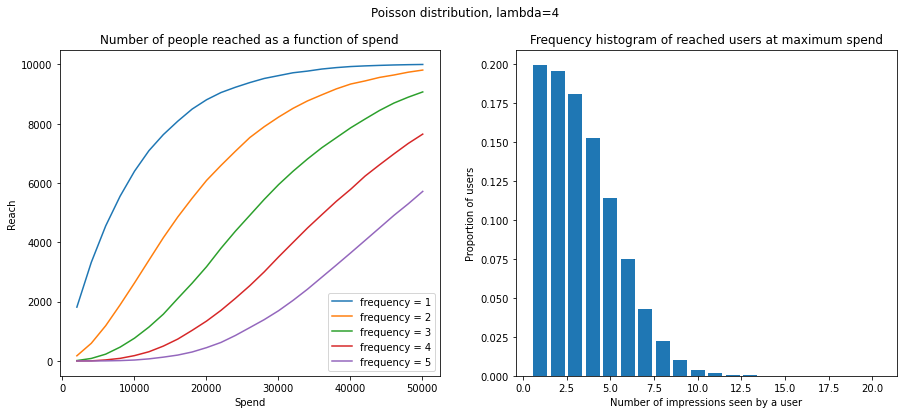

In [8]:
plot_dataset(dataset0)

In [9]:
# Verify that the mean and variance of the underlying data is as expected.

mean_frequency(dataset0), var_frequency(dataset0)

(5.0129, 3.98873359)

## Exponential-Poisson Distribution

In advertising data, it has been observed that many users are reached with  higher frequency that would be predicted by a Poisson distribution.  The Exponentional-Poisson distribution is a variation of the Poisson distribution that has higher dispersion.  

Like the Poisson distribution, the Exponentional-Poisson distribution has only a single parameter, which in this case is often labeled $\beta$.  To randomly draw an impression count from an Exponential-Poisson distribution, one starts by drawing a random value $\lambda$ from an Exponential distribution with parameter $\beta$.  One then draws the impression count from a shifted Poisson distribution with parameter $\lambda$.

The probability mass function of the Exponential-Poisson distribution is as follows:

$$ Pr(k | \beta) = \frac{\beta}{(1 + \beta)^k}, k=1,2,3,...$$

The mean of the Exponential-Poisson distribution is $\beta + 1$, and the variance is $\beta(\beta + 1)$.

One advantage of the Exponential-Poisson distribution is that it can easily be fit from a single reach value.  See [this paper](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/43218.pdf) for details.

In [10]:
ep_beta = average_frequency - 1
data1 = HeterogeneousImpressionGenerator(audience_size, gamma_shape=1., gamma_scale=ep_beta)()
publisher1 = PublisherData(FixedPriceGenerator(price_per_impression)(data1))
dataset1 = DataSet([publisher1], f"Exponential-poisson, beta={ep_beta}")

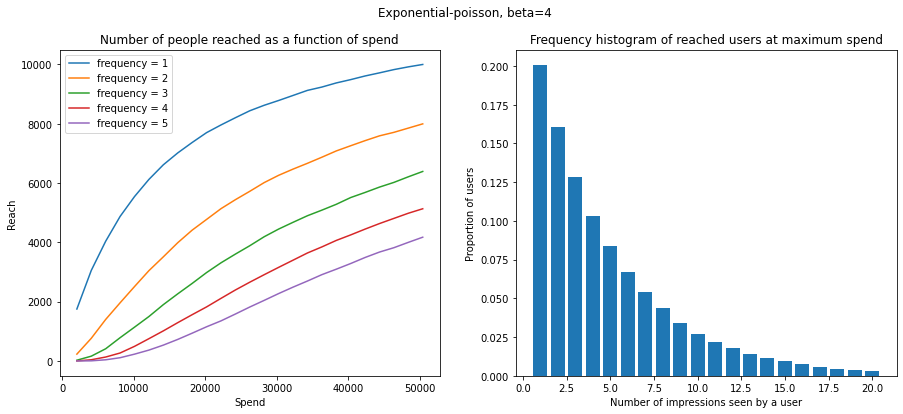

In [11]:
plot_dataset(dataset1)

In [12]:
# Verify that the mean and variance of the underlying data is as expected.

mean_frequency(dataset1), var_frequency(dataset1)

(5.0415, 20.112377750000004)

## Gamma-Poisson Distribution A - Low Variance

The Gamma-Poisson distribution is widely used in modeling advertising data.  It is given by two parameters, $\alpha$ and $\beta$.  To draw an impression count from the Gamma-Poisson distribution, one first draws a value $\lambda$ from a Gamma distribution with parameters $\alpha$ and $\beta$.  The impression count is then drawn from a Poisson distribution with parameter $\lambda$.

An advantage of the Gamma-Poisson distribution is that it allows greater modeling flexibility than the Exponential-Poisson.  The mean and the variance can each be chosen independently, as long as the variance is at least as large as the mean.  The Exponential-Poisson is a special case of the Gamma-Poisson, which is obtained by settting $\alpha=1$.

The Gamma-Poisson distribution is equivalent to the [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution).  Making use of this equivalence, the probability mass function for the Gamma-Poisson distribution can be succinctly given as follows:

$$Pr(k | \alpha, \beta) = \frac{\Gamma(\alpha + k-1)}{\Gamma(k)\Gamma(\alpha)}\left(\frac{1}{1+\beta}\right)^{k-1}\left(\frac{\beta}{1 + \beta}\right)^{\alpha}.$$

The mean of the Gamma-Poisson distribution is $\alpha\beta+1$, and the variance is $\alpha\beta(\beta+1)$.

In this colab, we consider two instances of a Gamma-Poisson distribution.  In one instance, the variance is set to a relatively value.  This should give results somewhere between the Poisson and the Exponential-Poisson.  In the other example, we set the variance to a relatively high value.  This should give results similar to the Zeta (Zipf) distribution.


In [13]:
target_variance = average_frequency + 1
p = 1 - (average_frequency - 1) / target_variance
r = (average_frequency - 1) * (1 - p) / p
gp_alpha_a = r
gp_beta_a = p / (1 - p)
data2 = HeterogeneousImpressionGenerator(audience_size, gamma_shape=gp_alpha_a, gamma_scale=gp_beta_a)()
publisher2 = PublisherData(FixedPriceGenerator(price_per_impression)(data2))
dataset2 = DataSet([publisher2], f"Gamma-poisson A, alpha={gp_alpha_a}, beta={gp_beta_a}")
p, r, gp_alpha_a, gp_beta_a

(0.33333333333333337, 7.999999999999999, 7.999999999999999, 0.5000000000000001)

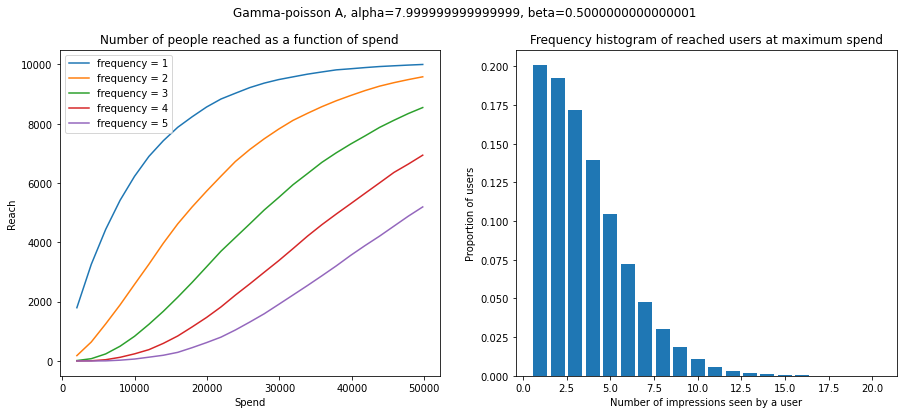

In [14]:
plot_dataset(dataset2)

In [15]:
# Verify that the mean and variance of the underlying data is as expected.

mean_frequency(dataset2), var_frequency(dataset2)

(4.98, 6.155)

In [16]:
# Analytically compute mean and variance by making use of equivalence
# to negative binomial distribution.
r = gp_alpha_a
p = gp_beta_a / (1 + gp_beta_a)
mu=1+p*r/(1-p) 
sigma2=p * r / (1 - p)**2
mu, sigma2


(5.000000000000002, 6.0000000000000036)

## Gamma-Poisson Distribution B - High Variance



In [17]:
target_variance = 4 * average_frequency**2
p = 1 - (average_frequency - 1) / target_variance
r = (average_frequency - 1) * (1 - p) / p
gp_alpha_b = r
gp_beta_b = p / (1 - p)
data3 = HeterogeneousImpressionGenerator(audience_size, gamma_shape=gp_alpha_b, gamma_scale=gp_beta_b)()
publisher3 = PublisherData(FixedPriceGenerator(price_per_impression)(data3))
dataset3 = DataSet([publisher3], f"Gamma-poisson B, alpha={gp_alpha_b}, beta={gp_beta_b}")

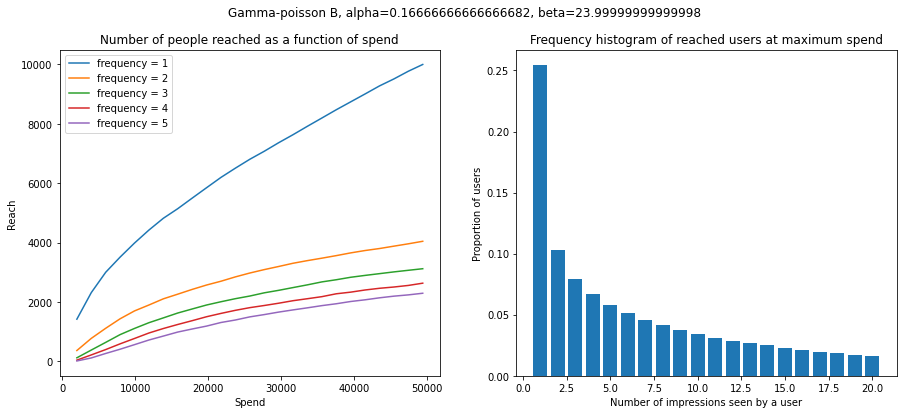

In [18]:
plot_dataset(dataset3)

In [19]:
# Verify that the mean and variance of the underlying data is as expected.

mean_frequency(dataset3), var_frequency(dataset3)

(4.9422, 97.66385916)

## Zeta (Heavy-tailed) Distribution

The [Zeta distribution](https://en.wikipedia.org/wiki/Zeta_distribution) is a distribution that favors relatively large numbers of viewers at high frequencies.  The Zeta distribution is associated with [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), which postulates that the probability of a viewer receiving k impressions is inversely proportional to a power of k.  Zipf's law has been applied in many other contexts.

The Zeta distribution is described by a single parameter $s$.  The probability mass function is given as follows:

$$\Pr(k | s) = \frac{k^{-s}}{\zeta(s)}, \textrm{ where } \zeta(s)=\sum_{k=1}^\infty \frac{1}{k^{-s}}.$$

The mean of the Zeta distribution is only defined if $s > 2$.  In this case, the mean is given by $\mu = \zeta(s-1)/\zeta(s).$  The mean of the Zeta distribution decreases as a function of $s$.  The variance of the Zeta distribution is only defined for $s > 3$.  For $s=3$, the Zeta distribution has a mean of about 1.36, so the variance is only defined when the mean is less than this value.  Nonetheless,  


In [20]:
from scipy.stats import zipf
from scipy.optimize import minimize_scalar

zeta_s = minimize_scalar(lambda x: (zipf.mean(x) - average_frequency)**2, bounds=(2.001,100), options={'disp':False}, method='Bounded').x
data4 = HeavyTailedImpressionGenerator(audience_size, zeta_s,
                                       random_generator=np.random.default_rng(seed=4))()
publisher4 = PublisherData(FixedPriceGenerator(price_per_impression)(data4))
dataset4 = DataSet([publisher4], f"Zeta, s={zeta_s}")
zeta_s, zipf.mean(zeta_s), zipf.var(zeta_s)

(2.1416287975894543, 5.00005007989467, inf)

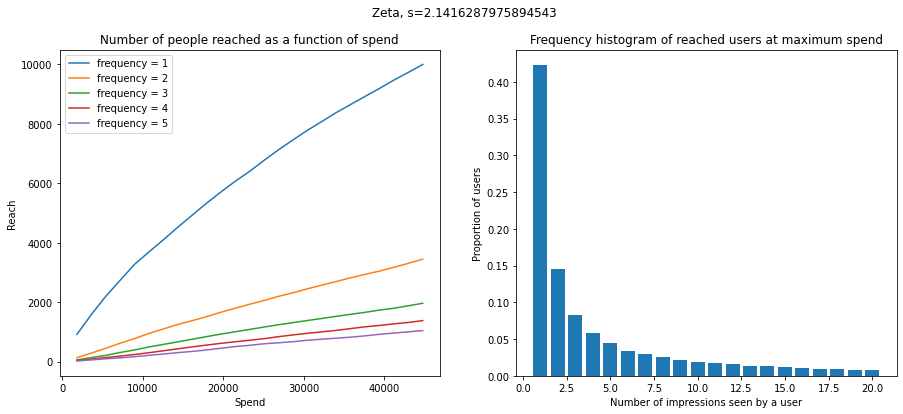

In [21]:
plot_dataset(dataset4)

In [22]:
# Verify that the mean and variance of the underlying data is as expected.
# Note that the value of the variance can differ greatly from the target value.  
# That is because the variance is actually undefined when the mean is above
# about 1.36.

mean_frequency(dataset4), var_frequency(dataset4)

(4.4781, 16161.27192039001)

## All distributions

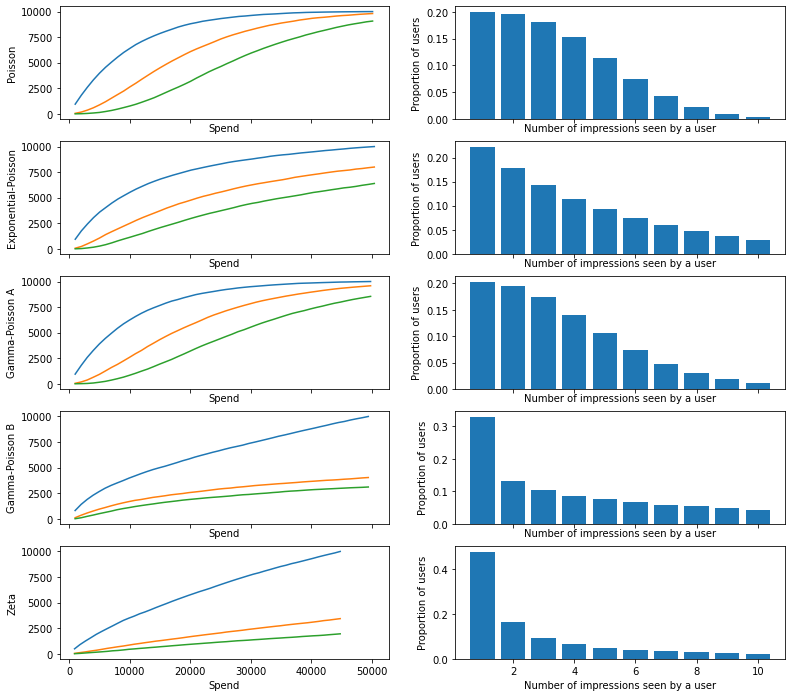

In [23]:
  datasets = [dataset0, dataset1, dataset2, dataset3, dataset4]
  names = ['Poisson', 'Exponential-Poisson', 'Gamma-Poisson A', 'Gamma-Poisson B', 'Zeta']
  fig,axs = plt.subplots(len(datasets), 2, figsize=(13, 12), sharex='col')

  for i in range(len(datasets)):
    plot_dataset_reach_curves(datasets[i], axs[i][0], include_legend=False, include_title=False)
    axs[i][0].set_ylabel(names[i])
    plot_dataset_frequency_histogram(datasets[i], axs[i][1], histogram_bins=max(10, 2*average_frequency), include_title=False)

## Basic Model Fitting

#### <font color="red">The following value determines the point along the reach curve that is used for training.  In other words, the simulated campaign reaches this point.  The value is given as a fraction of maximum possible spend.

In [24]:
spend_fraction = 0.5

In [61]:
def point_at_spend_fraction(dataset, sf, max_frequency=10):
  spend = dataset._data[0].max_spend * sf
  point = dataset.reach_by_spend([spend], max_frequency=max_frequency)
  return point

def plot_reach_curve_from_data(dataset, max_spend, ax=None, points_to_plot=50, max_frequency=3, color="tab:blue", include_legend=True):
  if ax is None:
    fig,ax=plt.subplots()

  xvals = []
  reach_points = []
  for i in range(points_to_plot):
    x = max_spend * (i + 1) / points_to_plot
    y = dataset.reach_by_spend([x], max_frequency=max_frequency)
    xvals.append(x)
    reach_points.append(y)
        
  label = "True reach"
  for f in range(max_frequency):
    yvals = []
    for p in reach_points:
      yvals.append(p.reach(f+1))
    ax.plot(xvals, yvals, label=label, color=color, linewidth=1)
    label = None

  if include_legend:
    ax.legend()

def plot_reach_curve_from_model(curve, max_spend, ax=None, points_to_plot=50, label="model", linestyle=":", max_frequency=3, color="g", include_legend=True):
  if ax is None:
    fig,ax=plt.subplots()

  curve_max_spend = curve.spend_at_reach_quantile(0.999)
  xvals = []
  reach_points = []
  for i in range(points_to_plot):
    x = max_spend * (i + 1) / points_to_plot
    if x <= curve_max_spend:
      y = curve.by_spend([x], max_frequency=max_frequency)
    else:
      y = curve.by_spend([curve_max_spend], max_frequency=max_frequency)
    xvals.append(x)
    reach_points.append(y)

  for f in range(1, max_frequency+1):
    yvals = [y.reach(f) for y in reach_points]
    ax.plot(xvals, yvals, linestyle, label=label, color=color, marker="o", ms=3)
    label=None

  if include_legend:
    ax.legend()

def plot_model_frequency_histogram(dataset, model_dict, spend, ax=None, histogram_bins=10):
  if ax is None:
    fig,ax=plt.subplots()

  group_width = 0.8
  item_width = group_width / (2 + len(model_dict))
  data_point = dataset.reach_by_spend([spend], max_frequency=histogram_bins)
  data_freqs = np.array([data_point.reach(f) for f in range(1,histogram_bins+1)])
  data_freqs = data_freqs / sum(data_freqs)
  ax.bar(np.arange(1,len(data_freqs)+1), data_freqs, width=2*item_width, label='True', align='edge')

  offset = item_width
  colors = ["forestgreen", "brown", "goldenrod"]
  for model_name, curve in model_dict.items():
    offset += item_width
    model_point = curve.by_spend([spend], max_frequency=histogram_bins)
    model_freqs = np.array([model_point.reach(f) for f in range(1,histogram_bins+1)])
    model_freqs = model_freqs / sum(model_freqs)
    ax.bar(np.arange(1,len(model_freqs)+1) + offset, model_freqs, width=item_width, label=model_name, align='edge', alpha=0.5, color=colors[0])
    colors = colors[1:]

  ax.legend()
  ax.set_title("Frequency histogram at campaign spend point")

def plot_reach_curves_with_data_and_models(dataset, model_dict, spend_fraction, ax=None, points_to_plot=20, include_legend=True, max_frequency=3):
  if ax is None:
    fig,ax=plt.subplots()
  
  max_spend = dataset._data[0].max_spend
  plot_reach_curve_from_data(dataset, max_spend, ax, include_legend=False, max_frequency=max_frequency, points_to_plot=points_to_plot)

  colors = ["forestgreen", "brown", "goldenrod"]
  for model_name, curve in model_dict.items():
    plot_reach_curve_from_model(curve, max_spend, ax, include_legend=False, max_frequency=max_frequency, 
                                points_to_plot=points_to_plot, color=colors[0], label=model_name)
    colors = colors[1:]

  reach_point = point_at_spend_fraction(dataset, spend_fraction)
  rx = reach_point.spends[0]
  for f in range(1, max_frequency+1):
    ax.plot(rx, reach_point.reach(f), 'ro', marker='x', ms=8)

  if include_legend:
    ax.legend()
  #ax.set_title(dataset.name)

def plot_reach_curves_and_histogram_with_data_and_models(dataset, model_dict, spend_fraction, ax=None, points_to_plot=20, include_legend=True, max_frequency=3):
  fig,(ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
  reach_point = point_at_spend_fraction(dataset, spend_fraction)
  plot_reach_curves_with_data_and_models(dataset, model_dict, spend_fraction, ax1, 
                                         points_to_plot=points_to_plot,
                                         max_frequency=max_frequency)
  plot_model_frequency_histogram(dataset, model_dict, reach_point.spends[0], ax2) 

def plot_oneplus_reach_curves_and_histogram_with_data_and_models(dataset, model_dict, spend_fraction, ax=None, points_to_plot=20, include_legend=True):
  fig,(ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
  reach_point = point_at_spend_fraction(dataset, spend_fraction)
  plot_reach_curves_with_data_and_models(dataset, model_dict, spend_fraction, ax1, 
                                         points_to_plot=points_to_plot,
                                         max_frequency=1)
  ax1.set_title("1+ reach")
  plot_model_frequency_histogram(dataset, model_dict, reach_point.spends[0], ax2) 




### Goerg Model fit to Poisson data


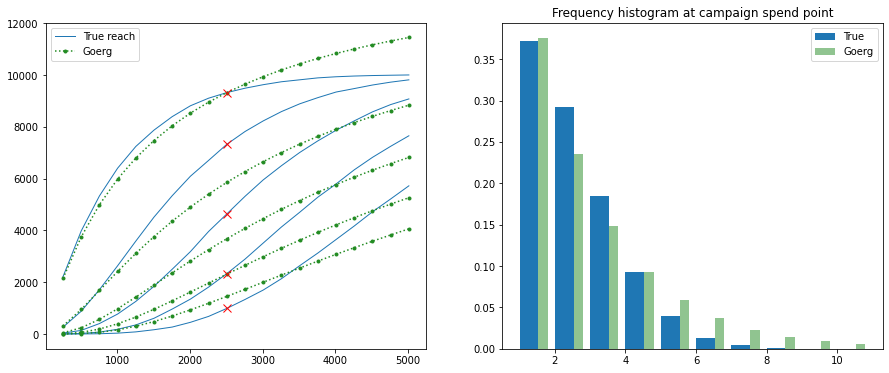

In [26]:
dataset = dataset0
rp = point_at_spend_fraction(dataset, spend_fraction)
gm = GoergModel([rp])
plot_reach_curves_and_histogram_with_data_and_models(dataset, {'Goerg': gm}, spend_fraction, max_frequency=5)

### Goerg Model fit to Exponential-Poisson Data

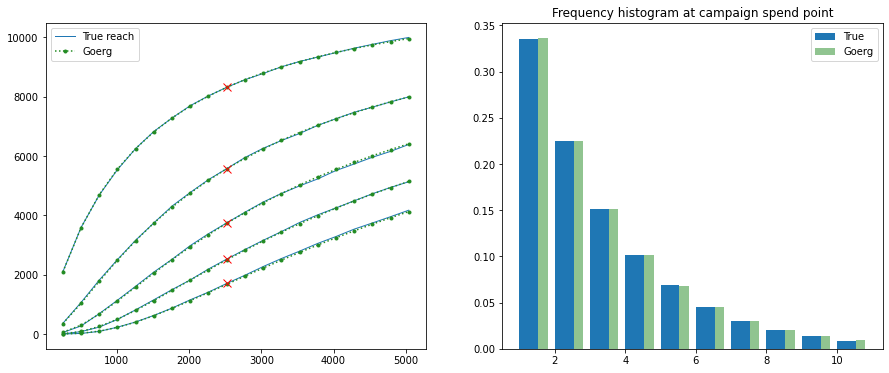

In [27]:
dataset = dataset1
rp = point_at_spend_fraction(dataset, spend_fraction)
gm = GoergModel([rp])
plot_reach_curves_and_histogram_with_data_and_models(dataset, {'Goerg': gm}, spend_fraction, max_frequency=5)

### Goerg Model fit to Gamma-Poisson A


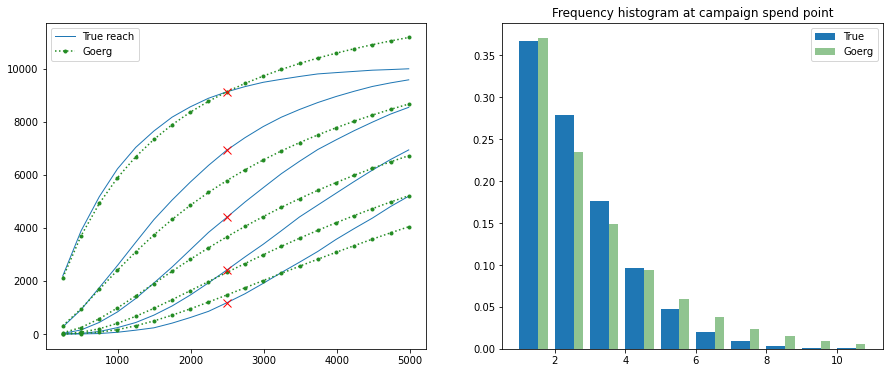

In [28]:
dataset = dataset2
rp = point_at_spend_fraction(dataset, spend_fraction)
gm = GoergModel([rp])
plot_reach_curves_and_histogram_with_data_and_models(dataset, {'Goerg': gm}, spend_fraction, max_frequency=5)

### Goerg Model fit to Gamma-Poisson B


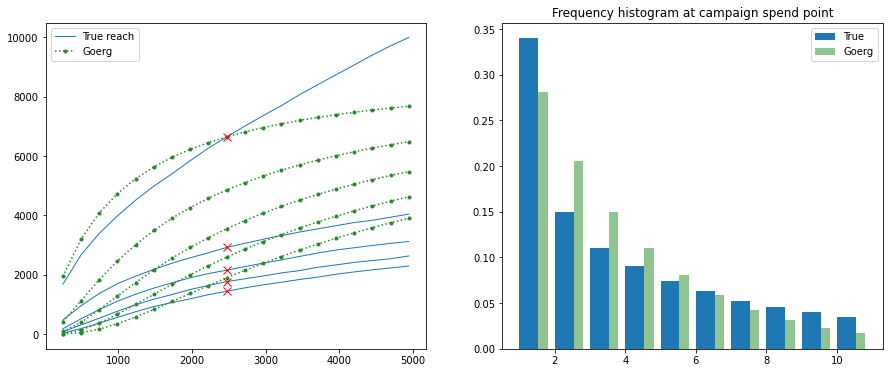

In [29]:
dataset = dataset3
rp = point_at_spend_fraction(dataset, spend_fraction)
gm = GoergModel([rp])
plot_reach_curves_and_histogram_with_data_and_models(dataset, {'Goerg': gm}, spend_fraction, max_frequency=5)

### Goerg Model fit to Zeta distribution

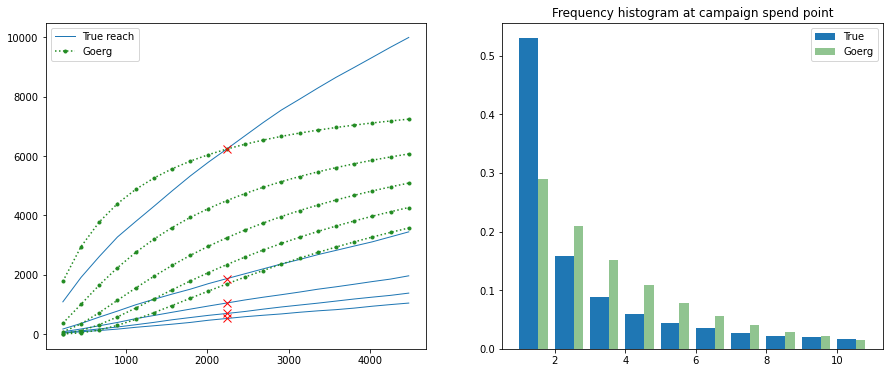

In [30]:
dataset = dataset4
rp = point_at_spend_fraction(dataset, spend_fraction)
gm = GoergModel([rp])
plot_reach_curves_and_histogram_with_data_and_models(dataset, {'Goerg': gm}, spend_fraction, max_frequency=5)

### Gamma-Poisson Model fit to Poisson data

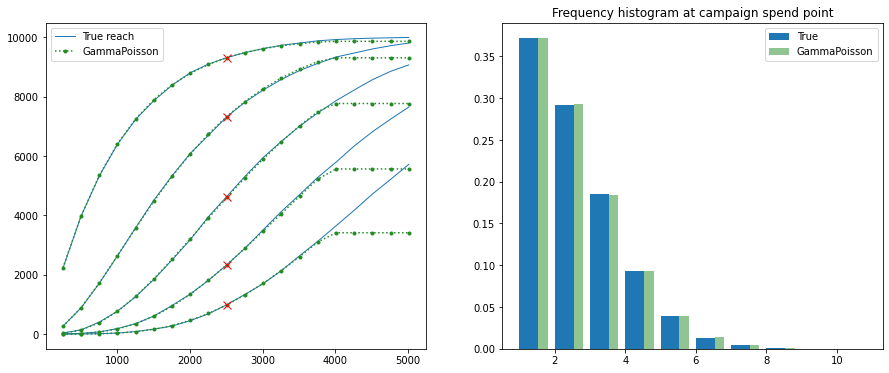

In [63]:
dataset = dataset0
rp = point_at_spend_fraction(dataset, spend_fraction)
gpm = GammaPoissonModel([rp])
gpm._fit()
plot_reach_curves_and_histogram_with_data_and_models(dataset, {'GammaPoisson': gpm}, spend_fraction, max_frequency=5)

### Gamma-Poisson Model fit to Exponential-Poisson data

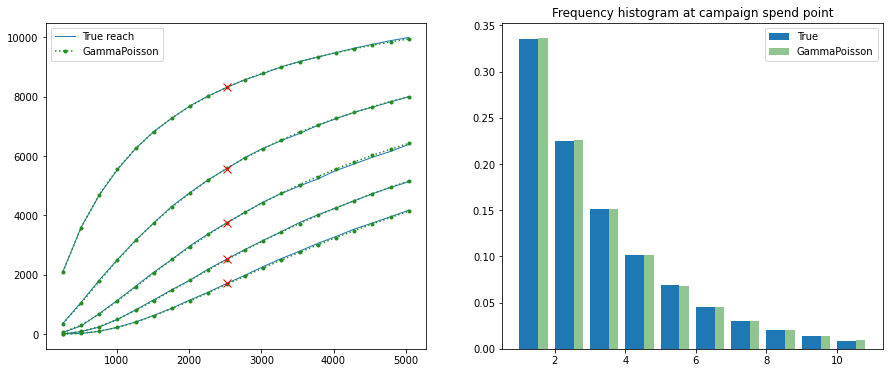

In [64]:
dataset = dataset1
rp = point_at_spend_fraction(dataset, spend_fraction)
gpm = GammaPoissonModel([rp])
gpm._fit()
plot_reach_curves_and_histogram_with_data_and_models(dataset, {'GammaPoisson': gpm}, spend_fraction, max_frequency=5)

### Gamma-Poisson Model fit to Gamma-Poisson Data A (low variance)

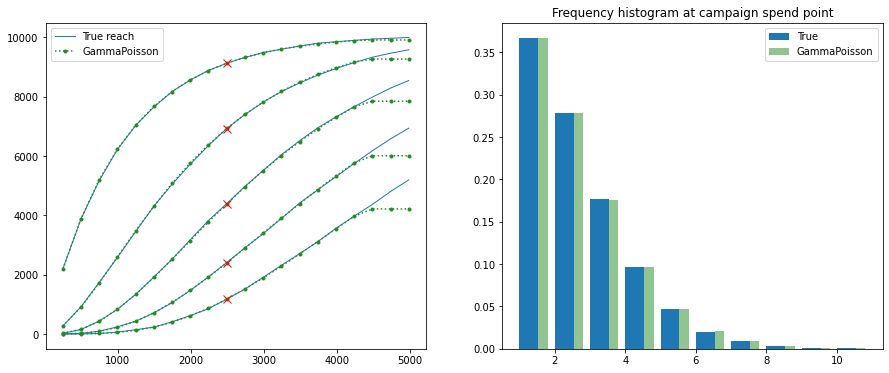

In [65]:
dataset = dataset2
rp = point_at_spend_fraction(dataset, spend_fraction)
gpm = GammaPoissonModel([rp])
gpm._fit()
plot_reach_curves_and_histogram_with_data_and_models(dataset, {'GammaPoisson': gpm}, spend_fraction, max_frequency=5)

### Gamma-Poisson Model fit to Gamma-Poisson Data B (high variance)

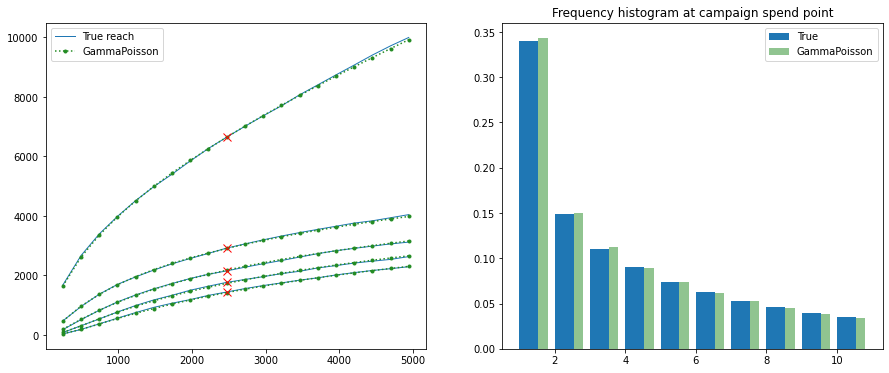

In [66]:
dataset = dataset3
rp = point_at_spend_fraction(dataset, spend_fraction)
gpm = GammaPoissonModel([rp])
gpm._fit()
plot_reach_curves_and_histogram_with_data_and_models(dataset, {'GammaPoisson': gpm}, spend_fraction, max_frequency=5)

### Gamma-Poisson Model fit to Zeta distribution

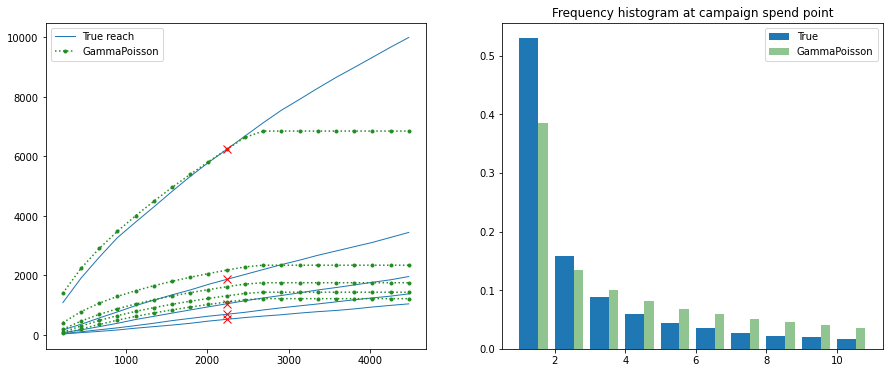

In [67]:
dataset = dataset4
rp = point_at_spend_fraction(dataset, spend_fraction)
gpm = GammaPoissonModel([rp])
gpm._fit()
plot_reach_curves_and_histogram_with_data_and_models(dataset, {'GammaPoisson': gpm}, spend_fraction, max_frequency=5)

### Comparison of Goerg to Gamma-Poisson on Poisson data

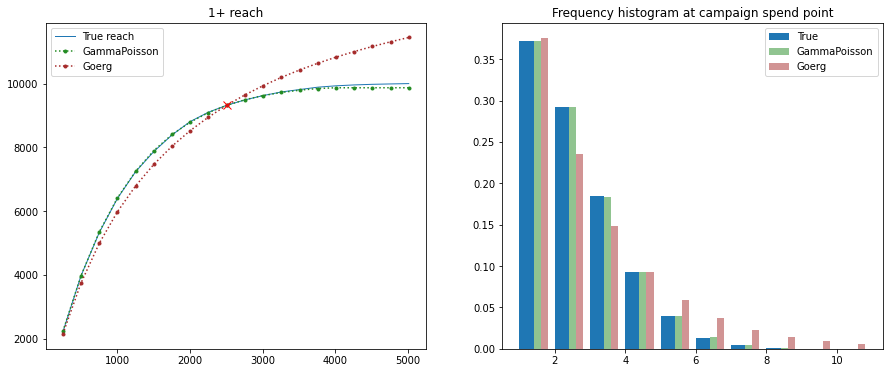

In [68]:
dataset = dataset0
rp = point_at_spend_fraction(dataset, spend_fraction)
gm = GoergModel([rp])
gpm = GammaPoissonModel([rp])
gpm._fit()
plot_oneplus_reach_curves_and_histogram_with_data_and_models(dataset, {'GammaPoisson': gpm, 'Goerg': gm}, spend_fraction)

### Comparison of Goerg to Gamma-Poisson on Exponential-Poisson data

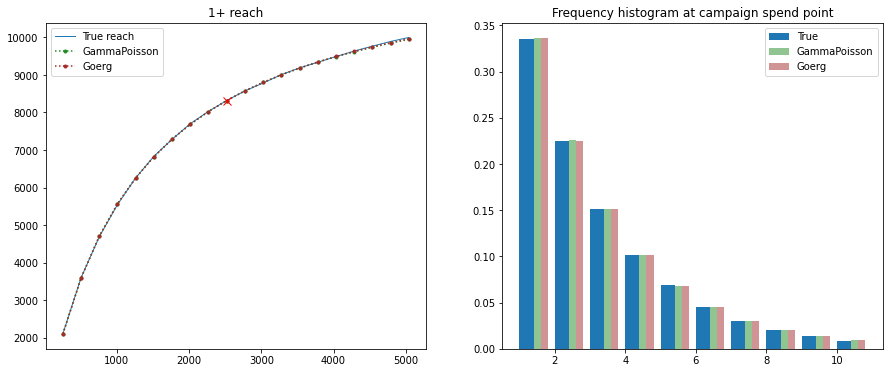

In [69]:
dataset = dataset1
rp = point_at_spend_fraction(dataset, spend_fraction)
gm = GoergModel([rp])
gpm = GammaPoissonModel([rp])
gpm._fit()
plot_oneplus_reach_curves_and_histogram_with_data_and_models(dataset, {'GammaPoisson': gpm, 'Goerg': gm}, spend_fraction)

### Comparison of Goerg to Gamma-Poisson on Gamma-Poisson A (low variance)

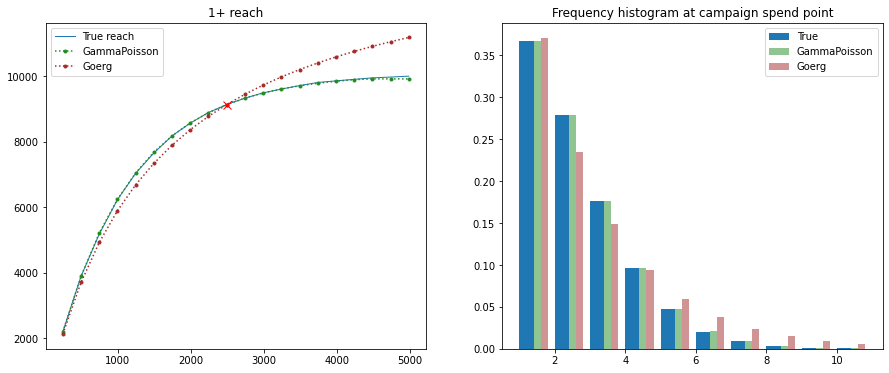

In [70]:
dataset = dataset2
rp = point_at_spend_fraction(dataset, spend_fraction)
gm = GoergModel([rp])
gpm = GammaPoissonModel([rp])
gpm._fit()
plot_oneplus_reach_curves_and_histogram_with_data_and_models(dataset, {'GammaPoisson': gpm, 'Goerg': gm}, spend_fraction)

### Comparison of Goerg to Gamma-Poisson on Gamma-Poisson B (high variance)

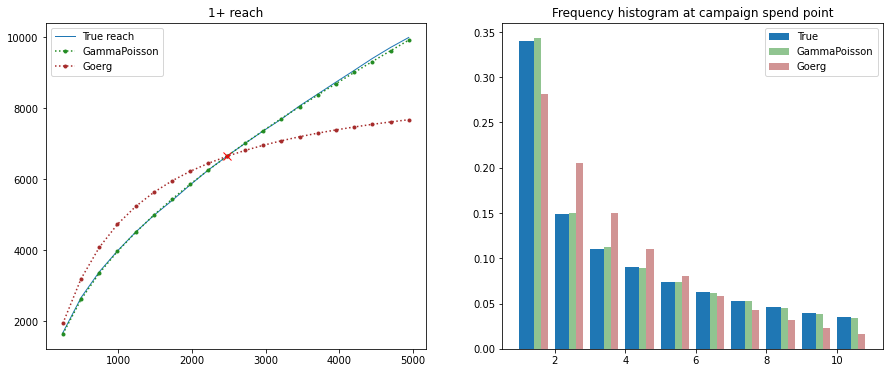

In [71]:
dataset = dataset3
rp = point_at_spend_fraction(dataset, spend_fraction)
gm = GoergModel([rp])
gpm = GammaPoissonModel([rp])
gpm._fit()
plot_oneplus_reach_curves_and_histogram_with_data_and_models(dataset, {'GammaPoisson': gpm, 'Goerg': gm}, spend_fraction)

### Comparison of Goerg to Gamma-Poisson on Zeta distribution


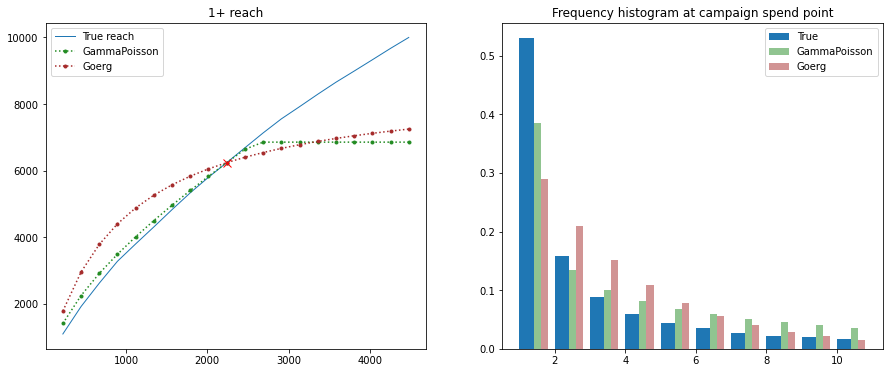

In [72]:
dataset = dataset4
rp = point_at_spend_fraction(dataset, spend_fraction)
gm = GoergModel([rp])
gpm = GammaPoissonModel([rp])
gpm._fit()
plot_oneplus_reach_curves_and_histogram_with_data_and_models(dataset, {'GammaPoisson': gpm, 'Goerg': gm}, spend_fraction)